Credits: https://www.kaggle.com/allohvk/titanic-missing-age-imputation-tutorial-advanced

https://www.kaggle.com/dimkarodin/titanic-sklearn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
df_test.shape

(418, 11)

In [6]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [8]:
df_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [9]:
df_test.shape

(418, 11)

In [10]:
all_data = pd.concat((df_train,df_test)).reset_index(drop=True)

In [11]:
all_data.shape

(1309, 12)

# Impute missing Age
We can't just drop the missing values because age is an important indicator of survival. Younger people tend to have a better chance of survival due to the evacuation policy.

In [12]:
all_data.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

People with the title "Master" are likely young. Let's take the mean of the ages of all the people with the "Master" title.

In [13]:
# Using only df_train to prevent data leakage from test to train data.
print(df_train[df_train.Name.str.contains('Master')]['Age'].mean())

4.574166666666667


In [14]:
# These young masters should not be traveling alone, so they should ideally have Parch > 0. Let's see if there's any children
# traveling alone.
display((all_data[(all_data.Age.isnull()) & (all_data.Name.str.contains('Master')) & (all_data.Parch==0)]))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1230,1231,NaN,3,"Betros, Master. Seman",male,NaN,0,0,2622,7.2292,NaN,C


Found one kid traveling alone. An outlier. We'll assume this kid is a little older than the average, say, 14.

In [15]:
#set the outlier to age 14
df_test.loc[df_test.PassengerId==1231,'Age']=14

Now to fill up the remaining ages. We will need create a new feature called "Title" extracted from the "Name" column.

In [16]:
df_train['Title'], df_test['Title'] = [df.Name.str.extract \
        (' ([A-Za-z]+)\.', expand=False) for df in [df_train, df_test]]

This code can be read from right to left and is a 'list comprehension' which is executed as follows:

-for each dataframe df in list of dataframes'

-extract title'

-store result in a new column in the 2 dataframes'

Now let's print the average age across Titles and Pclass.

In [17]:
df_train.groupby(['Title','Pclass'])['Age'].agg(['mean','count'])

mean  count
Title    Pclass                  
Capt     1       70.000000      1
Col      1       58.000000      2
Countess 1       33.000000      1
Don      1       40.000000      1
Dr       1       43.750000      4
         2       38.500000      2
Jonkheer 1       38.000000      1
Lady     1       48.000000      1
Major    1       48.500000      2
Master   1        5.306667      3
         2        2.258889      9
         3        5.350833     24
Miss     1       30.000000     45
         2       22.390625     32
         3       16.123188     69
Mlle     1       24.000000      2
Mme      1       24.000000      1
Mr       1       41.580460     87
         2       32.768293     82
         3       28.724891    229
Mrs      1       40.882353     34
         2       33.682927     41
         3       33.515152     33
Ms       2       28.000000      1
Rev      2       43.166667      6
Sir      1       49.000000      1

The mean age differs across Pclass (e.g. mean age of 'Mrs' in Pclass 1 is 40 vs. 33 in other Pclasses). May not matter much, but it could mean the difference in competitions.

Also, there are too many titles. Let's consolidate and create a few important ones, else this will cause too much noise.

In [18]:
TitleDict = {"Capt": "Officer","Col": "Officer","Major": "Officer","Jonkheer": "Royalty", \
             "Don": "Royalty", "Sir" : "Royalty","Dr": "Royalty","Rev": "Royalty", \
             "Countess":"Royalty", "Mme": "Mrs", "Mlle": "Miss", "Ms": "Mrs","Mr" : "Mr", \
             "Mrs" : "Mrs","Miss" : "Miss","Master" : "Master","Lady" : "Royalty"}

Dr. and Rev are not royalty, but they seem to match that age group.

Now let's map the titles to the corresponding value in the dictionary. 

In [19]:
df_train['Title'], df_test['Title'] = [df.Title.map(TitleDict) for df in [df_train, df_test]]

df_train.groupby(['Title', 'Pclass'])['Age'].agg(['mean', 'count'])

mean  count
Title   Pclass                  
Master  1        5.306667      3
        2        2.258889      9
        3        5.350833     24
Miss    1       29.744681     47
        2       22.390625     32
        3       16.123188     69
Mr      1       41.580460     87
        2       32.768293     82
        3       28.724891    229
Mrs     1       40.400000     35
        2       33.547619     42
        3       33.515152     33
Officer 1       56.600000      5
Royalty 1       42.555556      9
        2       42.000000      8

The mean is what will be fed to the missing ages as a function Title and Pclass.

In [20]:
all_data = df_train.append(df_test)
display(df_train[df_train.Title.isnull()])
display(df_test[df_test.Title.isnull()])

# There is a Dona which is royalty that is not covered in df_test. Let's update it
df_test.at[414,'Title'] = 'Royalty'

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9,C105,C,NaN


Now all titles are in shape. We can groupby Pclass, Sex, Royalty and find the mean and then plug in all the missing Age values.

Here's a pertinent question. 

How much does the numerical value of age contribute to the survival? Let us say you spend hours writing some nifty code to arrive at an age of 31 instead of 38 for a missing age passenger (and it turns out her actual age happens to be 31). Will it make a lot of difference to her survival? __The answer is NO.__

__There are other factors which are far more important
HOWEVER the fact whether the person is a child or an adult or a senior citizen DOES play a critical role in survival.__
So long as one can categorize the missing ages as belonging to one of this group it is fine! In particular, we should be spending a lot more time worrying about whether the person in question (with the missing age) was a child or not? This makes a lot of difference to the survival chance. How do we do that? Well it is easy for male children because of the Title 'Master' which is prefixed to their names. But how do we identify a female child among the missing ages. There is no Title specific to female children. All unmarried females across all ages had the 'Miss' Title. So here is a simple way to identify such folks and impute their missing ages. I haven't seen it being used in any kernel so far (at least the ones I have gone thru' though). We can identify the such cases by checking the Parch flag. If Parch flag is >0 then they are most likely female children.

In [21]:
print ("Avg age of 'Miss' Title", round(df_train[df_train.Title=="Miss"]['Age'].mean()))

print ("Avg age of 'Miss' Title travelling without Parents", round(df_train[(df_train.Title=="Miss") & (df_train.Parch==0)]['Age'].mean()))

print ("Avg age of 'Miss' Title travelling with Parents", round(df_train[(df_train.Title=="Miss") & (df_train.Parch!=0)]['Age'].mean()), '\n')

Avg age of 'Miss' Title 22
Avg age of 'Miss' Title travelling without Parents 28
Avg age of 'Miss' Title travelling with Parents 12 



A significant difference. Without considering the Parch, this would have been off by a lot.

In [22]:
men = df_train.loc[df_train['Sex'] == 'male']['Survived']
perc_men = sum(men)/len(men)*100

print("% of men who survived:", perc_men)

% of men who survived: 18.890814558058924


In [23]:
##Let us turn our attention to the missing fare
display(all_data[all_data.Fare.isnull()])

##Let us get fare per person
for df in [df_train, df_test, all_data]:
    df['PeopleInTicket']=df['Ticket'].map(all_data['Ticket'].value_counts())
    df['FarePerPerson']=df['Fare']/df['PeopleInTicket']

##Just take the mean fare for the PORT S and the Pclass & fill it. Remember to consider FarePerPerson and not Fare
print('Mean fare for this category: ', df_train[(df_train.Embarked=='S') & (df_train.Pclass==3)]['FarePerPerson'].mean())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
152,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,Mr


Mean fare for this category:  7.382647773383368


In [24]:
df_test.loc[df_test.Fare.isnull(), ['Fare','FarePerPerson']] = round(df_train[(df_train.Embarked=='S') & (df_train.Pclass==3) & (df_train.PeopleInTicket==1)]['Fare'].mean(),1)

In [25]:
# Let's look at the two missing rows for Embarked
display(all_data[all_data.Embarked.isnull()])

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,PeopleInTicket,FarePerPerson
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Miss,2,40.0
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Mrs,2,40.0


In [26]:
##Let us groupby Embarked and check some statistics
df_train[(df_train.Pclass==1)].groupby('Embarked').agg({'FarePerPerson': 'mean', 'Fare': 'mean', 'PassengerId': 'count'})

,FarePerPerson,Fare,PassengerId
Embarked,,,
C,39.179223,104.718529,85
Q,30.000000,90.000000,2
S,30.211849,70.364862,127


In [27]:
##Only 1 family got on at Q. Also fare is 30 per person and this is definitely not the case
##From the data below, it seems fairly obvious that the fareperperson of 40 for the 2 missing cases maps to Port C

##Let us check same data for groups of 2 adults
df_train[(df_train.Pclass==1) & (df_train.PeopleInTicket==2) & (df_train.Age>18)].groupby('Embarked').agg({'FarePerPerson': 'mean', 'Fare': 'mean', 'PassengerId': 'count'})

,FarePerPerson,Fare,PassengerId
Embarked,,,
C,35.073648,70.147296,23
S,31.702411,63.404822,32


In [28]:
print(df_train[(~df_train.Cabin.isnull()) & (df_train.Pclass==1) & (df_train.PeopleInTicket==2) & (df_train.Sex=="female") & (df_train.Age>18)].groupby('Embarked').agg({'FarePerPerson': 'mean', 'Fare': 'mean', 'PassengerId': 'count'}))

##Still port C comes out as a winner in all cases. We will go ahead with this
df_train.Embarked.fillna('C', inplace=True)

          FarePerPerson      Fare  PassengerId
Embarked                                      
C              36.19730  72.39460           10
S              31.61042  63.22084           10


Now to fill the remaining missing ages with the mean values. Only one problem. The title "Miss" varies widely, so we need to create a new title called "FemaleChild".

In [29]:
print(df_train.groupby(['Pclass','Sex','Title'])['Age'].agg({'mean', 'median', 'count'}))

for df in [df_train, df_test, all_data]:
    df.loc[(df.Title=='Miss') & (df.Parch!=0) & (df.PeopleInTicket>1), 'Title']="FemaleChild"

display(all_data[(all_data.Age.isnull()) & (all_data.Title=='FemaleChild')])

                       count  median       mean
Pclass Sex    Title                            
1      female Miss        47    30.0  29.744681
              Mrs         35    40.0  40.400000
              Royalty      3    48.0  43.333333
       male   Master       3     4.0   5.306667
              Mr          87    40.0  41.580460
              Officer      5    56.0  56.600000
              Royalty      6    42.0  42.166667
2      female Miss        32    24.0  22.390625
              Mrs         42    31.5  33.547619
       male   Master       9     1.0   2.258889
              Mr          82    31.0  32.768293
              Royalty      8    46.5  42.000000
3      female Miss        69    18.0  16.123188
              Mrs         33    31.0  33.515152
       male   Master      24     4.0   5.350833
              Mr         229    26.0  28.724891


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,PeopleInTicket,FarePerPerson
128,129,1.0,3,"Peter, Miss. Anna",female,NaN,1,1,2668,22.3583,F E69,C,FemaleChild,3,7.452767
180,181,0.0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.5500,NaN,S,FemaleChild,11,6.322727
229,230,0.0,3,"Lefebre, Miss. Mathilde",female,NaN,3,1,4133,25.4667,NaN,S,FemaleChild,5,5.093340
409,410,0.0,3,"Lefebre, Miss. Ida",female,NaN,3,1,4133,25.4667,NaN,S,FemaleChild,5,5.093340
485,486,0.0,3,"Lefebre, Miss. Jeannie",female,NaN,3,1,4133,25.4667,NaN,S,FemaleChild,5,5.093340
792,793,0.0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.5500,NaN,S,FemaleChild,11,6.322727
863,864,0.0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S,FemaleChild,11,6.322727
888,889,0.0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,FemaleChild,4,5.862500
188,1080,NaN,3,"Sage, Miss. Ada",female,NaN,8,2,CA. 2343,69.5500,NaN,S,FemaleChild,11,6.322727


In [30]:
## you can use the transform function, but not recommended. This will leak values from the test dataset.
##[df['Age'].fillna(df.groupby(['Pclass','Sex','Title'])['Age'].transform('mean'), inplace=True) for df in [train_data, test_data]]

In [31]:
##Define a group containing all the parameters you want, do a mean
##You can print the below group. This will be our lookup table
grp = df_train.groupby(['Pclass','Sex','Title'])['Age'].mean()
print(grp)

Pclass  Sex     Title      
1       female  FemaleChild    21.071429
                Miss           33.424242
                Mrs            40.400000
                Royalty        43.333333
        male    Master          5.306667
                Mr             41.580460
                Officer        56.600000
                Royalty        42.166667
2       female  FemaleChild     9.916667
                Miss           29.875000
                Mrs            33.547619
        male    Master          2.258889
                Mr             32.768293
                Royalty        42.000000
3       female  FemaleChild     6.500000
                Miss           21.590909
                Mrs            33.515152
        male    Master          5.350833
                Mr             28.724891
Name: Age, dtype: float64


In [32]:
# grp is similar to a list
##So let us convert this 'series' object into a 'dataframe' 
##We use the reset-index feature. This is an important tool
grp = df_train.groupby(['Pclass','Sex','Title'])['Age'].mean().reset_index()[['Sex', 'Pclass', 'Title', 'Age']]

print('\n', 'We converted the series object to: ', type(grp))


 We converted the series object to:  <class 'pandas.core.frame.DataFrame'>


In [33]:
print('\n', 'Lookup works like a charm now but not quite: ', grp[(grp.Pclass==2) & (grp.Sex=='male') & (grp.Title=='Master')]['Age'])


 Lookup works like a charm now but not quite:  11    2.258889
Name: Age, dtype: float64


In [34]:
##There is still one minor change. The above lookup returns a series object
##You can print the type() and see for yourself.
##Even though the series object has only ONE row, however Python does not know
##all that and if you try assigning that series object to the 'age' col of a 
##'single' row, it will crib BIG-TIME. So we do one last thing..read the value
##of the first (and only row). This will be a single number
print('\n', 'Here we go ', grp[(grp.Pclass==2) & (grp.Sex=='male') & (grp.Title=='Master')]['Age'].values[0])


 Here we go  2.2588888888888885


In [1]:
##Now the above lookup works perfectly. Pass it the Pclass, Sex, Title
##It can then tell you the (mean) age for that group. Let us use it

##Define a function called fill_age. This will lookup the combination
##passed to it using above lookup table and return the value of the age associated
def fill_age(x):
    return grp[(grp.Pclass==x.Pclass)&(grp.Sex==x.Sex)&(grp.Title==x.Title)]['Age'].values[0]
##Here 'x' is the row containing the missing age. We look up the row's Pclass
##Sex and Title against the lookup table as shown previously and return the Age
##Now we have to call this fill_age function for every missing row for test, train

df_train['Age'], df_test['Age'] = [df.apply(lambda x: fill_age(x) if np.isnan(x['Age']) else x['Age'], axis=1) for df in [df_train, df_test]]
##This line is explained in the next cell

##End by combining the test and training data
all_data=df_train.append(df_test)

NameError: name 'df_train' is not defined

In [36]:
df_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,PeopleInTicket,FarePerPerson
0,892,3,"Kelly, Mr. James",male,34.500000,0,0,330911,7.8292,NaN,Q,Mr,1,7.829200
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.000000,1,0,363272,7.0000,NaN,S,Mrs,1,7.000000
2,894,2,"Myles, Mr. Thomas Francis",male,62.000000,0,0,240276,9.6875,NaN,Q,Mr,1,9.687500
3,895,3,"Wirz, Mr. Albert",male,27.000000,0,0,315154,8.6625,NaN,S,Mr,1,8.662500
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.000000,1,1,3101298,12.2875,NaN,S,Mrs,2,6.143750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,28.724891,0,0,A.5. 3236,8.0500,NaN,S,Mr,1,8.050000
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.000000,0,0,PC 17758,108.9000,C105,C,Royalty,3,36.300000
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.500000,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,Mr,1,7.250000
416,1308,3,"Ware, Mr. Frederick",male,28.724891,0,0,359309,8.0500,NaN,S,Mr,1,8.050000


In [37]:
women = df_train.loc[df_train['Sex'] == 'female']['Survived']
perc_women = sum(women)/len(women)*100

print("% of men who survived:", perc_women)

% of men who survived: 74.20382165605095


<AxesSubplot:xlabel='Sex', ylabel='count'>

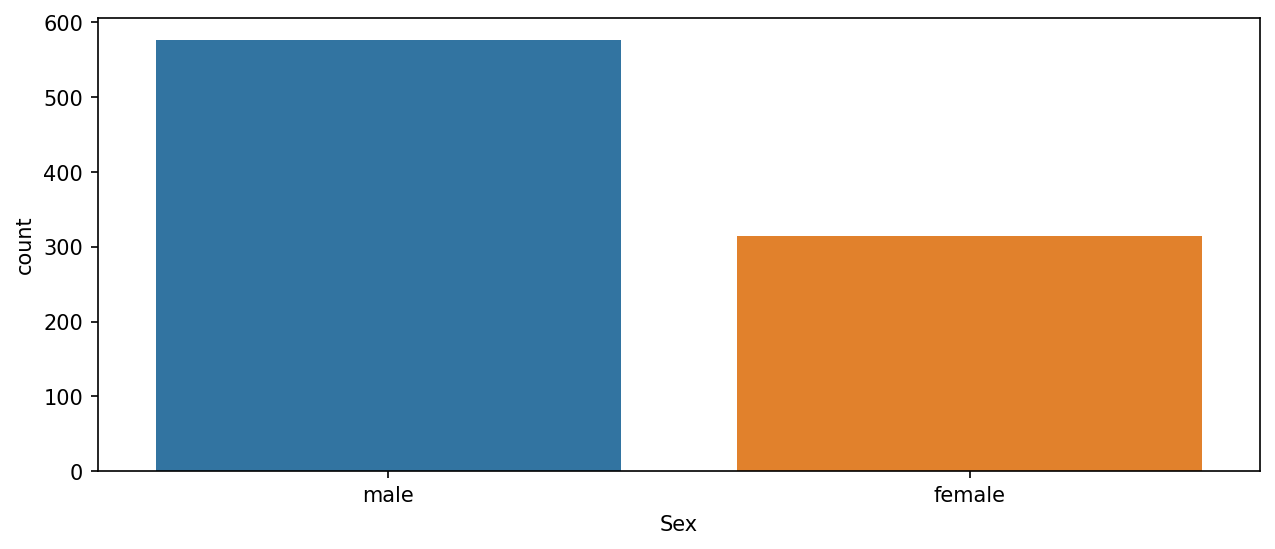

In [38]:
plt.figure(figsize=(10,4),dpi = 150)
sns.countplot(x = 'Sex', data = df_train, )

<AxesSubplot:>

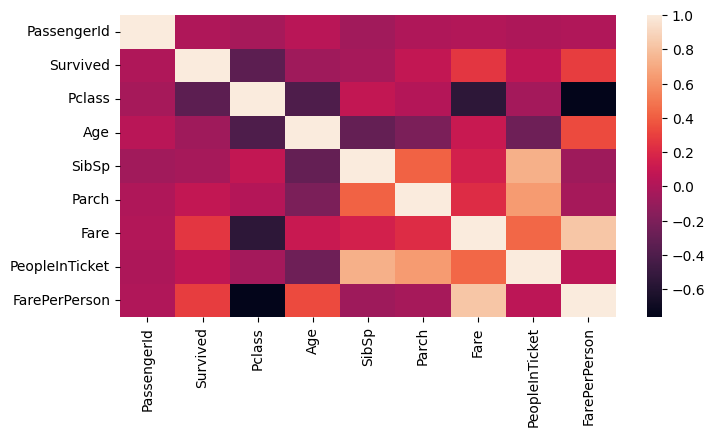

In [39]:
plt.figure(figsize=(8,4),dpi=100)
sns.heatmap(data =df_train.corr())

In [40]:
df_train.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,PeopleInTicket,FarePerPerson
PassengerId,1.000000,-0.005007,-0.035144,0.038214,-0.057527,-0.001652,0.012658,-0.006376,0.006161
Survived,-0.005007,1.000000,-0.338481,-0.063778,-0.035322,0.081629,0.257307,0.064962,0.288337
Pclass,-0.035144,-0.338481,1.000000,-0.400365,0.083081,0.018443,-0.549500,-0.039893,-0.762981
Age,0.038214,-0.063778,-0.400365,1.000000,-0.302064,-0.206454,0.108221,-0.263095,0.338360
SibSp,-0.057527,-0.035322,0.083081,-0.302064,1.000000,0.414838,0.159651,0.727331,-0.073529
Parch,-0.001652,0.081629,0.018443,-0.206454,0.414838,1.000000,0.216225,0.638361,-0.036442
Fare,0.012658,0.257307,-0.549500,0.108221,0.159651,0.216225,1.000000,0.436544,0.827073
PeopleInTicket,-0.006376,0.064962,-0.039893,-0.263095,0.727331,0.638361,0.436544,1.000000,0.054931
FarePerPerson,0.006161,0.288337,-0.762981,0.338360,-0.073529,-0.036442,0.827073,0.054931,1.000000


In [41]:
cols = df_train.corr().nlargest(6, 'Survived')['Survived'].index

In [42]:
most_corr = pd.DataFrame(cols)
most_corr.columns = ['Most Correlated Features']
most_corr

,Most Correlated Features
0,Survived
1,FarePerPerson
2,Fare
3,Parch
4,PeopleInTicket
5,PassengerId


<AxesSubplot:xlabel='Fare', ylabel='PassengerId'>

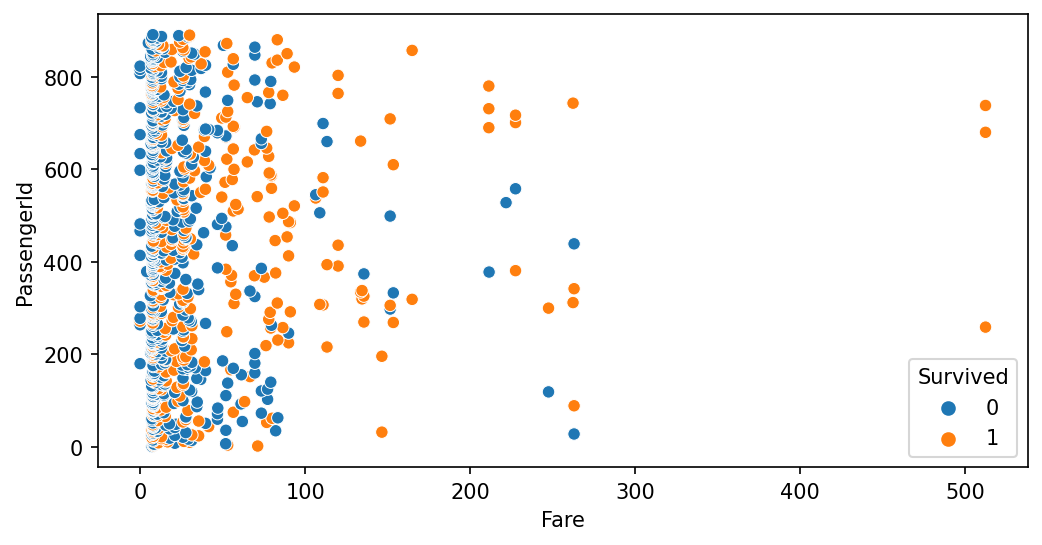

In [43]:
plt.figure(figsize=(8,4), dpi=150)
sns.scatterplot(data=df_train, x = 'Fare', y='PassengerId', hue='Survived')

In [44]:
ratio_died_fare = df_train.loc[df_train['Survived'] == 0]['Fare']

In [45]:
ratio_survived_fare = df_train.loc[df_train['Survived'] == 1]['Fare']

In [46]:
ratio_survived_fare.count()

342

In [47]:
ratio_died_fare.count()

549

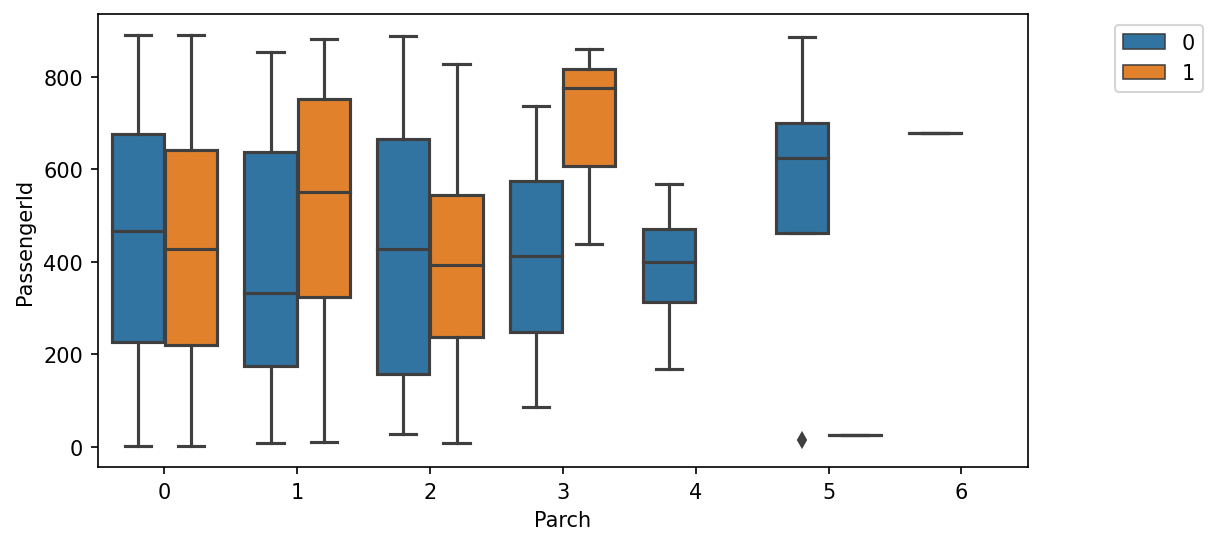

In [48]:
plt.figure(figsize=(8,4), dpi=150)
sns.boxplot(data=df_train, x = 'Parch', y='PassengerId', hue='Survived')
plt.legend(loc='upper right', bbox_to_anchor =(1.2,1));

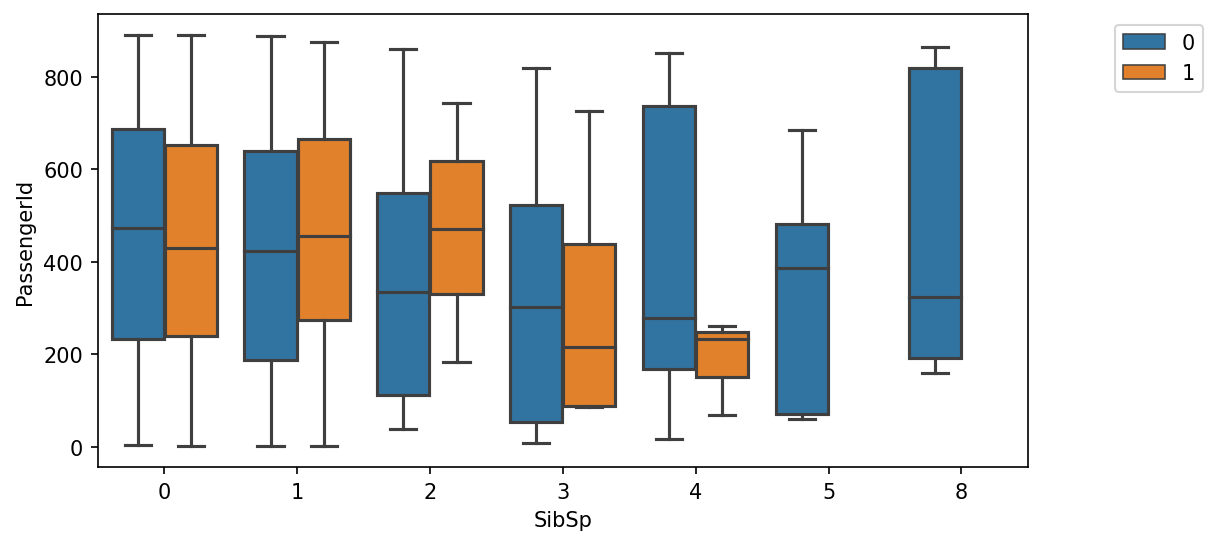

In [49]:
plt.figure(figsize=(8,4), dpi=150)
sns.boxplot(data=df_train, x = 'SibSp', y='PassengerId', hue='Survived')
plt.legend(loc='upper right', bbox_to_anchor =(1.2,1));

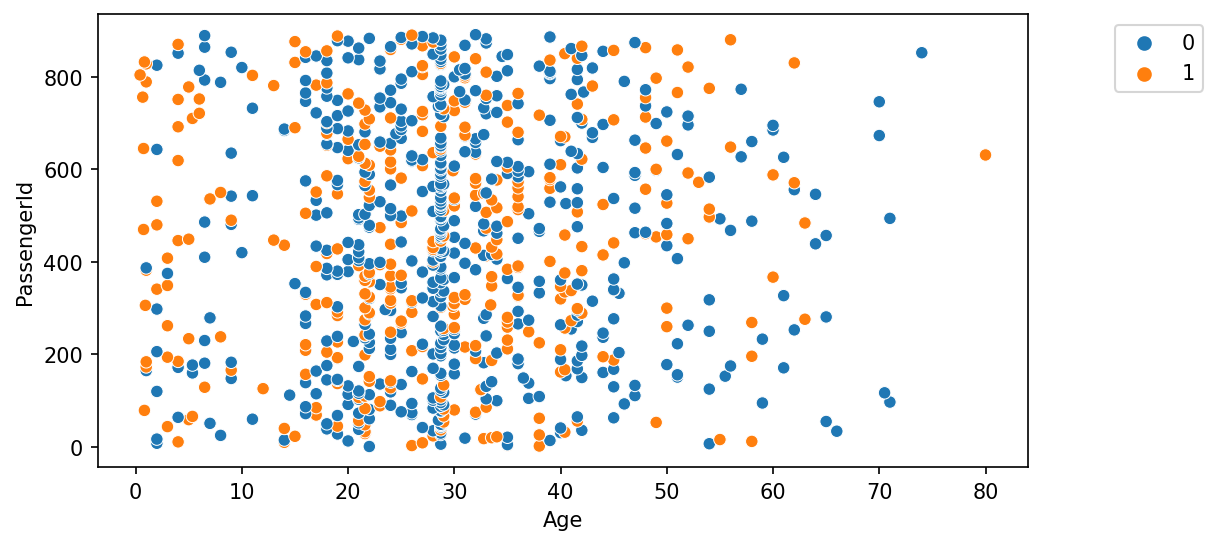

In [50]:
plt.figure(figsize=(8,4), dpi=150)
sns.scatterplot(data=df_train, x = 'Age', y='PassengerId', hue='Survived')
plt.legend(loc='upper right', bbox_to_anchor =(1.2,1));

In [51]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,PeopleInTicket,FarePerPerson
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,1,7.25000
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2,35.64165
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,1,7.92500
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,2,26.55000
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,1,8.05000


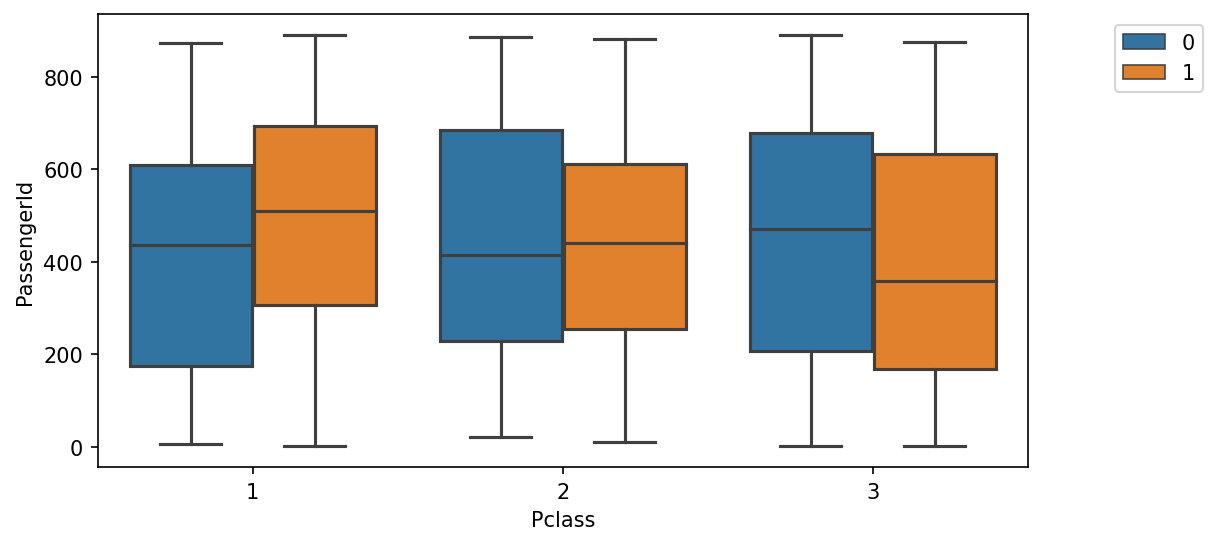

In [52]:
plt.figure(figsize=(8,4), dpi=150)
sns.boxplot(data=df_train, x = 'Pclass', y='PassengerId', hue='Survived')
plt.legend(loc='upper right', bbox_to_anchor =(1.2,1));

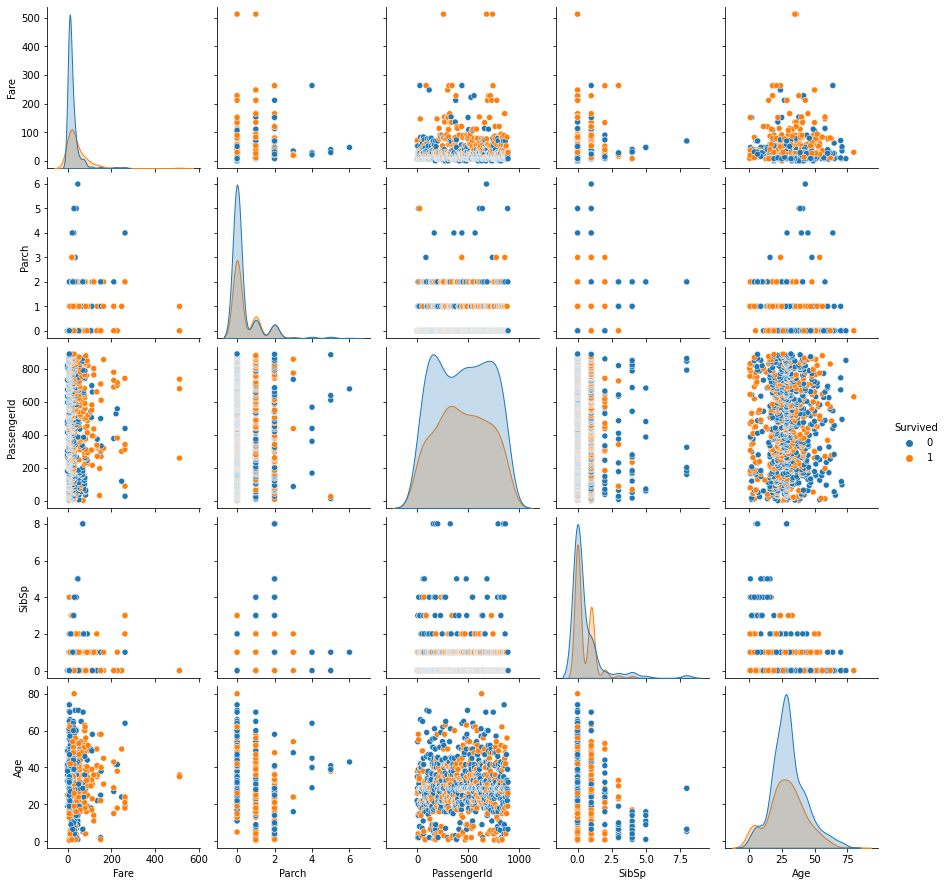

In [53]:
sns.pairplot(df_train[['Survived','Fare', 'Parch','PassengerId','SibSp','Age']],hue='Survived')

In [54]:
def categorize_int(ds, col, cols):
    ds[col] = ds[col].fillna(ds[col].mean())
    ds[col] = ds[col].astype(int)

    ds.loc[ds[col] <= cols[0], col] = 1
    for i, val in enumerate(cols):
        try:
            ds.loc[(ds[col] > val) & (ds[col] <= cols[i+1]), col] = i+2
        except IndexError:
            ds.loc[ds[col] > cols[-1], col] = i+1
    return ds

def categorize_str(data_frame, col, mapping):
    data_frame[col] = data_frame[col].map(mapping).astype(int)
    return data_frame

cols = [8, 17, 19, 21, 24, 26, 28, 30, 33, 36, 40, 46, 52]
train = categorize_int(train, 'Age', cols)
test = categorize_int(test, 'Age', cols)

In [55]:
#df_train['Age'] = df_train['Age'].astype(float)
df_train['Fare'] = df_train['Fare'].astype(float)
#df_test['Age'] = df_train['Age'].astype(float)
df_test['Fare'] = df_train['Fare'].astype(float)
df_train['new_Sex'] = np.where(df_train['Sex'] == 'male', 0, 1)
df_test['new_Sex'] = np.where(df_test['Sex'] == 'male', 0, 1)

In [56]:
columns_to_drop = ['Name', 'PassengerId','Ticket','Cabin','Embarked','Sex','Title','PeopleInTicket','FarePerPerson']

In [57]:
df_trainPID = df_train['PassengerId']
df_testPID = df_test['PassengerId']

In [58]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,PeopleInTicket,FarePerPerson,new_Sex
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,1,7.25000,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2,35.64165,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,1,7.92500,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,2,26.55000,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,1,8.05000,0


In [59]:
y_train = df_train['Survived']
X_train = df_train.drop(columns_to_drop +['Survived'],axis=1)
X_test = df_test.drop(columns_to_drop, axis=1)

In [60]:
X_train.head()

,Pclass,Age,SibSp,Parch,Fare,new_Sex
0,3,22.0,1,0,7.2500,0
1,1,38.0,1,0,71.2833,1
2,3,26.0,0,0,7.9250,1
3,1,35.0,1,0,53.1000,1
4,3,35.0,0,0,8.0500,0


In [61]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,PeopleInTicket,FarePerPerson,new_Sex
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.2500,NaN,Q,Mr,1,7.82920,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,71.2833,NaN,S,Mrs,1,7.00000,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,7.9250,NaN,Q,Mr,1,9.68750,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,53.1000,NaN,S,Mr,1,8.66250,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,8.0500,NaN,S,Mrs,2,6.14375,1


In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

In [63]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

logreg_y_pred = logreg.predict(X_test)
logreg_accuracy = logreg.score(X_train, y_train)
logreg_accuracy

0.8035914702581369

In [64]:
algorithms = [
    LogisticRegression(),
    SVC(),
    RandomForestClassifier(n_estimators=100),
    DecisionTreeClassifier(),
    SGDClassifier(),
    LinearSVC(),
    Perceptron(),
    GaussianNB(),
    KNeighborsClassifier(n_neighbors=3),
    LogisticRegressionCV(),
    MLPClassifier()
]

predictions = pd.DataFrame()

for alg in algorithms:
    res = alg.fit(X_train, y_train)
    y_pred = alg.predict(X_test)
    score = alg.score(X_train, y_train)
    results = {
        "alg": alg.__class__.__name__,
        "score": score,
        "y_pred": y_pred
    }
    predictions = predictions.append(results, ignore_index=True)

c:\users\ben\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [65]:
sorted_predictions = predictions.sort_values(by="score", ascending=False)
sorted_predictions.loc[:, predictions.columns != 'y_pred']

,alg,score
2,RandomForestClassifier,0.982043
3,DecisionTreeClassifier,0.982043
8,KNeighborsClassifier,0.847363
10,MLPClassifier,0.818182
0,LogisticRegression,0.803591
9,LogisticRegressionCV,0.803591
5,LinearSVC,0.797980
7,GaussianNB,0.792368
6,Perceptron,0.730640
1,SVC,0.687991


Now to apply stacking

In [68]:
level_one_base_models = [
    ('dt', DecisionTreeClassifier()),
    ('sgd', SGDClassifier()),
    ('mlp', MLPClassifier())
]

level_two_base_models = [
    ('svc', SVC()),
    ('rf', RandomForestClassifier(n_estimators=100)),
]

level_three_base_models = [
    ('perc', Perceptron()),
    ('gnb', GaussianNB()),
    ('knn', KNeighborsClassifier(n_neighbors=10)),
]

final_estimator = LinearSVC()

lvl_three_estimator = StackingClassifier(estimators=level_three_base_models, final_estimator=final_estimator)
lvl_two_estimator = StackingClassifier(estimators=level_two_base_models, final_estimator=lvl_three_estimator)
lvl_one_estimator = StackingClassifier(estimators=level_one_base_models, final_estimator=lvl_two_estimator)

In [69]:
stacking = lvl_one_estimator.fit(X_train, y_train)

c:\users\ben\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\ben\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\ben\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\ben\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization has

In [70]:
stacking.score(X_train, y_train)

0.8159371492704826

Stacking 

In [71]:
stacking_predict = stacking.predict(X_test)

In [73]:
output = pd.DataFrame({'PassengerId': df_testPID, 'Survived': sorted_predictions.iloc[0]["y_pred"]})
output.to_csv('titanic-sklearn-random-forests.csv', index=False)

output_stacked = pd.DataFrame({'PassengerId': df_testPID, 'Survived': stacking_predict})
output_stacked.to_csv('titanic-stacked-multi-layer.csv', index=False)

print("Your submission was successfully saved!")

Your submission was successfully saved!
